# Baseline Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Baseline model using traditional machine learning

## Loading Dependencies

In [1]:
from pathlib import Path
import re

import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT sentiment, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>100000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 60000) cat_samples, sentiment, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(sentiment)
WHERE sentiment != 1
GROUP BY sentiment
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Kebanyakan update tapi tdk ada perubahan signi...,1,0
1,Masakan narik dana refound mesti pakek ktp ngk...,1,0
2,Belanja pakai voucher banyak aturannya.kg jela...,1,0
3,Lazada babii!!! Nge halangin aja ni aplikasi,1,0
4,Penilaian ke pedagang ditahan sama pihak lazad...,1,0


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/venv/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sentiment', ylabel='count'>

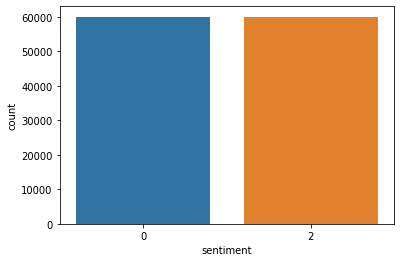

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       2
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119998 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     119998 non-null  object
 1   rating     119998 non-null  int64 
 2   sentiment  119998 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


### Cleaning

In [11]:
def extract_emojis(sentence):
    return [word for word in sentence.split() if str(word.encode('unicode-escape'))[2] == '\\' ]

In [12]:
def preprocessing_text(texts):
    emojis = ' '.join(extract_emojis(texts))
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = texts.lower()

    return texts + emojis

In [13]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [14]:
df.head()

,review,rating,sentiment,review_cleaned
0,Kebanyakan update tapi tdk ada perubahan signi...,1,0,kebanyakan update tapi tdk ada perubahan signi...
1,Masakan narik dana refound mesti pakek ktp ngk...,1,0,masakan narik dana refound mesti pakek ktp ngk...
2,Belanja pakai voucher banyak aturannya.kg jela...,1,0,belanja pakai voucher banyak aturannya kg jela...
3,Lazada babii!!! Nge halangin aja ni aplikasi,1,0,lazada babii nge halangin aja ni aplikasi
4,Penilaian ke pedagang ditahan sama pihak lazad...,1,0,penilaian ke pedagang ditahan sama pihak lazad...


In [15]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,119998.000000
mean,69.810539
std,89.517007
min,1.000000
25%,12.000000
50%,36.000000
75%,91.000000
max,1260.000000


word_length    180.0
Name: 0.9, dtype: float64

In [16]:
df['sentiment'] = df['sentiment'].map({0:0, 2:1})

## 2. Baseline model

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     15077
           1       0.88      0.91      0.89     14923

    accuracy                           0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000



<AxesSubplot:>

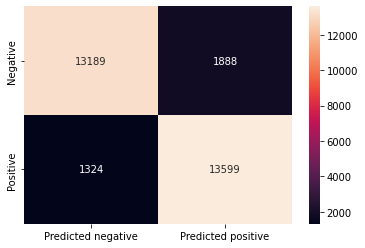

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression(max_iter=500))])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Serializing Model

In [18]:
from joblib import dump

In [19]:
MODEL_NAME = 'Baseline_Sentiment'
MODEL_VERSION = (3, 0, 1,'E')
MODEL_DIRNAME = '_'.join([MODEL_NAME, '.'.join(map(str, MODEL_VERSION))])
MODEL_FILENAME = 'Sentiment Analysis/Baseline/' + MODEL_DIRNAME + '/saved_model.joblib'

In [20]:
# Create folder if not exists
Path(MODEL_DIRNAME).mkdir(parents=True, exist_ok=True)

dump(pipeline, MODEL_FILENAME)

['Baseline_Sentiment_3.0.1.E/saved_model.joblib']